# Tutorial 9 - DIY KANs

In all previous tutorials we've been using the `KAN` class from `jaxkan.models.KAN` in order to define a network. However, if one requires more fine-grained access over the network's constituents, they may define their own custom KAN class by using one (or more) KAN Layers from the `jaxkan.layers` module.

In [1]:
from jaxkan.layers.RBF import RBFLayer
from jaxkan.layers.Sine import SineLayer

import jax
import jax.numpy as jnp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from flax import nnx
import optax

from typing import List

import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## Custom KAN Class

In general, the custom KAN class should inherit from `nnx.Module` and contain an `__init__` and `__call__` method. Apart from these, there are no other pre-requisites. For example, if one does not intend to perform grid updates, there is no need to define a `update_grids` method.

As an example, we will create a custom KAN class to perform the same function fitting task as in the first tutorial, this time using a mix of RBF Layers, Sine Layers and additional transformations in between.

In [2]:
class CustomKAN(nnx.Module):
    def __init__(self, rbf_layers, sine_layers, add_bias = True, seed = 42):

        self.RLayers = nnx.List([
                RBFLayer(
                    n_in = rbf_layers[i],
                    n_out = rbf_layers[i + 1],
                    D = 5,
                    kernel = {"type":"gaussian"},
                    add_bias = add_bias,
                    seed = seed
                )
                for i in range(len(rbf_layers)-1)
            ])

        self.SLayers = nnx.List([
                SineLayer(
                    n_in = sine_layers[i],
                    n_out = sine_layers[i + 1],
                    D = 8,
                    add_bias = add_bias,
                    seed = seed
                )
                for i in range(len(sine_layers)-1)
            ])

    def __call__(self, x):
        for layer in self.RLayers:
            x = layer(x)

        # Apply a GELU transformation
        x = nnx.gelu(x, approximate=True)

        for layer in self.SLayers:
            x = layer(x)

        return x

## Data Generation & Preprocessing

Again, we create data for the function $f(x, y) = x^2 + 2\exp(y)$.

In [3]:
def f(x,y):
    return x**2 + 2*jnp.exp(y)

def generate_data(minval=-1, maxval=1, num_samples=1000, seed=42):
    key = jax.random.PRNGKey(seed)
    x_key, y_key = jax.random.split(key)

    x1 = jax.random.uniform(x_key, shape=(num_samples,), minval=minval, maxval=maxval)
    x2 = jax.random.uniform(y_key, shape=(num_samples,), minval=minval, maxval=maxval)

    y = f(x1, x2).reshape(-1, 1)
    X = jnp.stack([x1, x2], axis=1)
    
    return X, y

In [4]:
seed = 42

X, y = generate_data(minval=-1, maxval=1, num_samples=1000, seed=seed)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Training

Let's now define an instance of the CustomKAN class, with 2 RBF Layers and 2 Sine Layers.

In [6]:
n_hidden = 5
rbf_layers = [X_train.shape[1], n_hidden, n_hidden]
sine_layers = [n_hidden, n_hidden, y_train.shape[1]]

# Sanity check for dimensions matching
assert rbf_layers[-1] == sine_layers[0]

model = CustomKAN(rbf_layers, sine_layers, True, 42)

In [7]:
opt_type = optax.adam(learning_rate=0.001)

optimizer = nnx.Optimizer(model, opt_type, wrt=nnx.Param)

In [8]:
# Define train loop
@nnx.jit
def train_step(model, optimizer, X_train, y_train):

    def loss_fn(model):
        residual = model(X_train) - y_train
        loss = jnp.mean((residual)**2)

        return loss
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(model, grads)
    
    return loss

In [9]:
# Initialize train_losses
num_epochs = 2000
train_losses = jnp.zeros((num_epochs,))

for epoch in range(num_epochs):
    # Calculate the loss
    loss = train_step(model, optimizer, X_train, y_train)
    
    # Append the loss
    train_losses = train_losses.at[epoch].set(loss)

## Evaluation

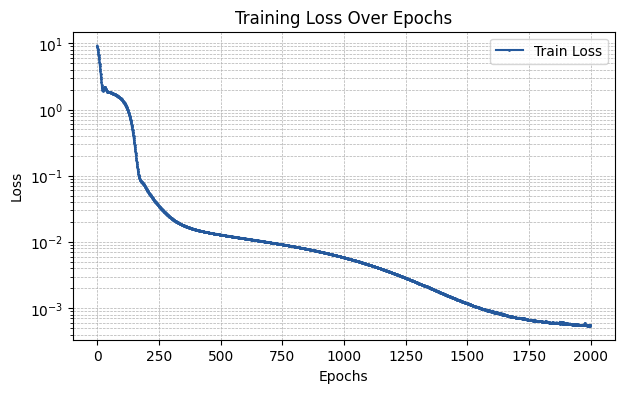

In [10]:
plt.figure(figsize=(7, 4))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

In [11]:
y_pred = model(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"The MSE of the fit is {mse:.5f}")

The MSE of the fit is 0.00061


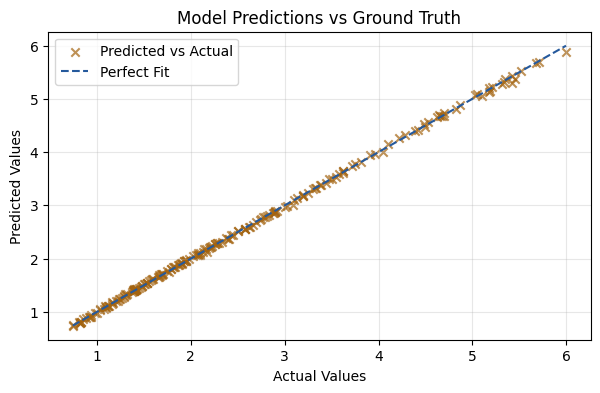

In [12]:
plt.figure(figsize=(7, 4))
plt.scatter(y_test, y_pred, alpha=0.7, color='#a3630f', marker='x', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#25599c', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs Ground Truth')
plt.legend()
plt.grid(alpha=0.3)
plt.show()